<a href="https://colab.research.google.com/github/mathewsjob/Master-Thesis/blob/main/Copy_of_extract_features_tl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, shutil
from google.colab import drive

In [2]:
import numpy as np
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications import InceptionV3

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
batch_size = 32
img_height = 244
img_width = 244

In [38]:
base_dir = '/content/drive/My Drive/Sample_Dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
data_dir = train_dir
valid_dir = os.path.join(base_dir, 'validate')

In [39]:
os.listdir(data_dir)

['dyed-lifted-polyps',
 'dyed-resection-margins',
 'esophagitis',
 'normal-cecum',
 'normal-pylorus',
 'normal-z-line',
 'polyps',
 'ulcerative-colitis']

In [40]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode = 'categorical')

Found 2000 files belonging to 8 classes.
Using 1600 files for training.


In [41]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  valid_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode = 'categorical')

Found 200 files belonging to 8 classes.
Using 40 files for validation.


In [42]:
train_all = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode = 'categorical')

Found 2000 files belonging to 8 classes.


# Augmentation and Normalization

In [43]:
def norm_data (ds):
  prepr_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
  #norm_ds = layer(ds)
  norm_ds = ds.map(lambda x, y: (prepr_layer(x), y))
  
  return norm_ds


In [44]:
def augument_data (ds, crop_size):
  prepr_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
  #norm_ds = layer(ds)
  norm_ds = ds.map(lambda x, y: (prepr_layer(x), y))

  layer1 = tf.keras.layers.experimental.preprocessing.CenterCrop(crop_size, crop_size)
  aug_ds = norm_ds.map(lambda x, y: (layer1(x), y))

  layer2 = tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(-0.05, 0.05) )
  aug_ds = aug_ds.map(lambda x, y: (layer2(x), y))

  layer3 = tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.1, -0.01), width_factor=(-0.1,  -0.01))
  aug_ds = aug_ds.map(lambda x, y: (layer3(x), y))
  
  return aug_ds


In [45]:
def augument_data1 (ds, crop_size):

  layer1 = tf.keras.layers.experimental.preprocessing.CenterCrop(crop_size, crop_size)
  aug_ds = ds.map(lambda x, y: (layer1(x), y))

  layer2 = tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(-0.05, 0.05) )
  aug_ds = aug_ds.map(lambda x, y: (layer2(x), y))

  layer3 = tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.1, -0.01), width_factor=(-0.1,  -0.01))
  aug_ds = aug_ds.map(lambda x, y: (layer3(x), y))
  
  return aug_ds



In [46]:
train_ds_aug = augument_data1 (train_ds, img_height-20)
train_ds_norm = norm_data (train_ds_aug)

In [47]:
val_ds_aug = augument_data1 (val_ds, img_height-20)
val_ds_norm = norm_data (val_ds_aug)

In [48]:
train_all_aug = augument_data1 (train_all, img_height-20)
train_all_norm = norm_data (train_all_aug)

In [49]:
# performance tuning
AUTOTUNE = tf.data.AUTOTUNE

train_ds_norm = train_ds_norm.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_norm = val_ds_norm.cache().prefetch(buffer_size=AUTOTUNE)
train_all_norm = train_all_norm.cache().prefetch(buffer_size=AUTOTUNE)


In [50]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_aug = train_ds_aug.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_aug = val_ds_aug.cache().prefetch(buffer_size=AUTOTUNE)
train_all_aug = train_all_aug.cache().prefetch(buffer_size=AUTOTUNE)

In [51]:
class_names = train_ds.class_names
print(class_names)

['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']


**Examples of original images:**

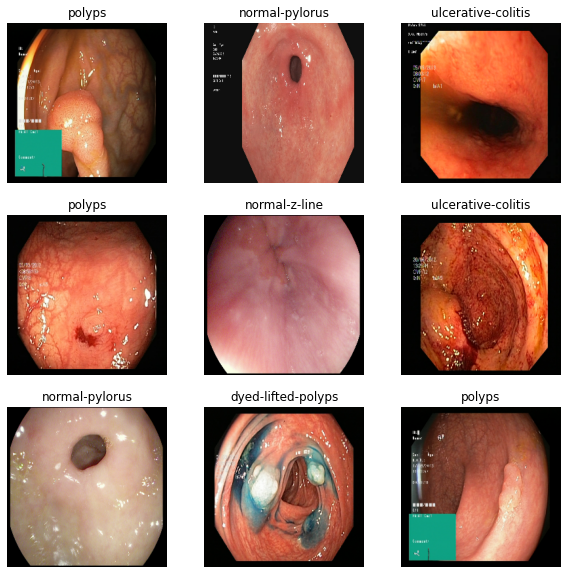

In [52]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

**Examples of augmented images:**

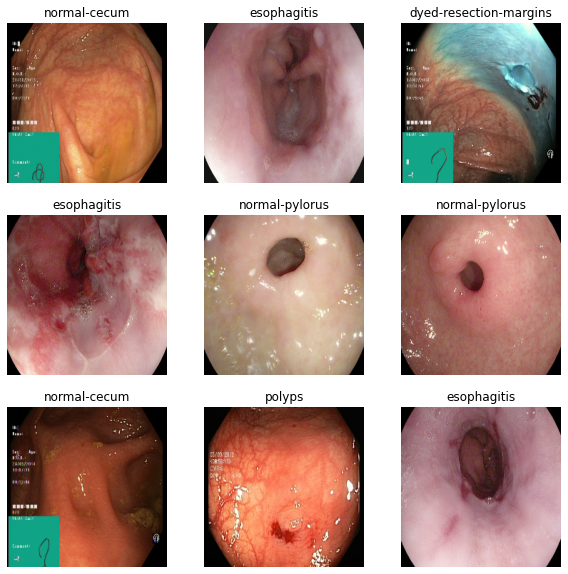

In [53]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(10, 10))
for images, labels in train_ds_aug.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

# Prepare Test dataset

In [54]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_width, img_height),
  batch_size=batch_size,
  label_mode = 'categorical')

Found 400 files belonging to 8 classes.


In [55]:
test_ds_aug = augument_data1 (test_ds, img_height-20)
test_ds_norm = norm_data (test_ds_aug)

In [56]:
AUTOTUNE = tf.data.AUTOTUNE
test_ds_norm = test_ds_norm.cache().prefetch(buffer_size=AUTOTUNE)

In [57]:
i = 0
y = np.zeros(shape=(400,8))
for inputs_batch, labels_batch in test_ds_norm:
  #print(inputs_batch.shape)
  y[i * batch_size : (i + 1) * batch_size] = labels_batch
  i += 1
  if i * batch_size >= 800:
      break

In [ ]:
y

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

# CNN Model



In [58]:

from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

from keras import layers
from keras import optimizers
from tensorflow.keras import regularizers

num_classes = 8

model2 = tf.keras.Sequential([
  layers.Conv2D(64, 3, activation='relu', input_shape=(224,224,3), padding='same',
                kernel_regularizer=regularizers.l2(1e-4)),
  layers.Conv2D(64, 3, activation='relu', padding='same',kernel_regularizer=regularizers.l2(1e-4)),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu',padding='same', kernel_regularizer=regularizers.l2(1e-4)),
  layers.Conv2D(128, 3, activation='relu',padding='same', kernel_regularizer=regularizers.l2(1e-4)),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation='relu',padding='same', kernel_regularizer=regularizers.l2(1e-4)),
  layers.Conv2D(256, 3, activation='relu',padding='same', kernel_regularizer=regularizers.l2(1e-4)),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.4),
  #layers.Dense(256, activation='relu'),
  #layers.Dropout(0.35),
  layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
  layers.Dropout(0.4),
  layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))
])

In [59]:
opt1=optimizers.RMSprop(learning_rate=2e-5)

In [60]:
opt2 = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.8)

In [61]:
opt3=optimizers.RMSprop(learning_rate=0.001)

In [62]:
model2.compile(
  optimizer=opt1,
  loss="categorical_crossentropy",
  metrics=['accuracy'])

In [63]:
hist_cnn_m2 = model2.fit(train_ds_norm,
  epochs=20,
  validation_data = val_ds_norm
)

Epoch 1/20
50/50 [==============================] - 86s 1s/step - loss: 1.6703 - accuracy: 0.3956 - val_loss: 1.1375 - val_accuracy: 0.6000
Epoch 2/20
50/50 [==============================] - 15s 298ms/step - loss: 1.1602 - accuracy: 0.5269 - val_loss: 0.9703 - val_accuracy: 0.6750
Epoch 3/20
50/50 [==============================] - 15s 300ms/step - loss: 1.0412 - accuracy: 0.5800 - val_loss: 0.9604 - val_accuracy: 0.6750
Epoch 4/20
50/50 [==============================] - 15s 302ms/step - loss: 0.9803 - accuracy: 0.6144 - val_loss: 0.9578 - val_accuracy: 0.6000
Epoch 5/20
50/50 [==============================] - 15s 305ms/step - loss: 0.9244 - accuracy: 0.6275 - val_loss: 0.7840 - val_accuracy: 0.7750
Epoch 6/20
50/50 [==============================] - 15s 308ms/step - loss: 0.8873 - accuracy: 0.6544 - val_loss: 0.8301 - val_accuracy: 0.7500
Epoch 7/20
50/50 [==============================] - 15s 308ms/step - loss: 0.8617 - accuracy: 0.6769 - val_loss: 0.7957 - val_accuracy: 0.7500
Ep

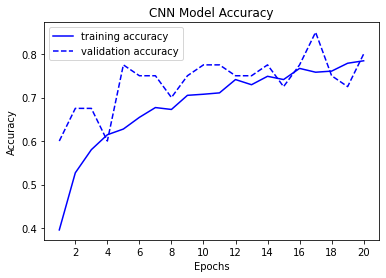

In [64]:
import matplotlib.pyplot as plt

acc = hist_cnn_m2.history['accuracy']
val_acc = hist_cnn_m2.history['val_accuracy']
loss = hist_cnn_m2.history['loss']
val_loss = hist_cnn_m2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.title('CNN Model Accuracy')
plt.plot(epochs, acc, 'b', label='training accuracy')
plt.plot(epochs, val_acc, 'b--', label='validation accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(np.arange(2, len(acc)+1, 2))
plt.legend()


plt.show()

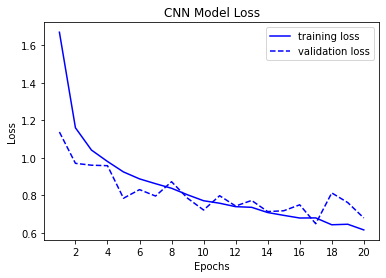

In [65]:


plt.title('CNN Model Loss')
plt.plot(epochs, loss, 'b', label='training loss')
plt.plot(epochs, val_loss, 'b--', label='validation loss')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(2, len(loss)+1, 2))
plt.legend()


plt.show()

In [66]:
hist_cnn_m2 = model2.fit(val_ds_norm,
  epochs=10,
  validation_data = train_ds_norm
)

Epoch 1/10
2/2 [==============================] - 7s 6s/step - loss: 0.5878 - accuracy: 0.8250 - val_loss: 0.9179 - val_accuracy: 0.6800
Epoch 2/10
2/2 [==============================] - 6s 5s/step - loss: 0.7851 - accuracy: 0.7000 - val_loss: 0.7783 - val_accuracy: 0.7156
Epoch 3/10
2/2 [==============================] - 5s 5s/step - loss: 0.5480 - accuracy: 0.8500 - val_loss: 0.9232 - val_accuracy: 0.6825
Epoch 4/10
2/2 [==============================] - 5s 5s/step - loss: 0.7056 - accuracy: 0.7750 - val_loss: 0.8808 - val_accuracy: 0.6950
Epoch 5/10
2/2 [==============================] - 5s 5s/step - loss: 0.4369 - accuracy: 0.8500 - val_loss: 0.7747 - val_accuracy: 0.7181
Epoch 6/10
2/2 [==============================] - 6s 5s/step - loss: 0.4764 - accuracy: 0.8500 - val_loss: 0.8173 - val_accuracy: 0.7031
Epoch 7/10
2/2 [==============================] - 5s 5s/step - loss: 0.3867 - accuracy: 0.8750 - val_loss: 0.7836 - val_accuracy: 0.7131
Epoch 8/10
2/2 [=========================

In [67]:
model2.evaluate(test_ds_norm)

13/13 [==============================] - 2s 193ms/step - loss: 1.1564 - accuracy: 0.6025


[1.1564089059829712, 0.6025000214576721]

In [68]:
test_pred = model2.predict(test_ds_norm)

13/13 [==============================] - 1s 104ms/step


In [69]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y[:800], axis=1), np.argmax(test_pred[:800], axis=1)))

              precision    recall  f1-score   support

           0       0.64      0.36      0.46        50
           1       0.58      0.76      0.66        50
           2       0.58      0.88      0.70        50
           3       0.52      0.96      0.68        50
           4       0.72      0.96      0.82        50
           5       0.67      0.16      0.26        50
           6       0.51      0.40      0.45        50
           7       0.81      0.34      0.48        50

    accuracy                           0.60       400
   macro avg       0.63      0.60      0.56       400
weighted avg       0.63      0.60      0.56       400



In [70]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y[:800], axis=1), np.argmax(test_pred[:800], axis=1))

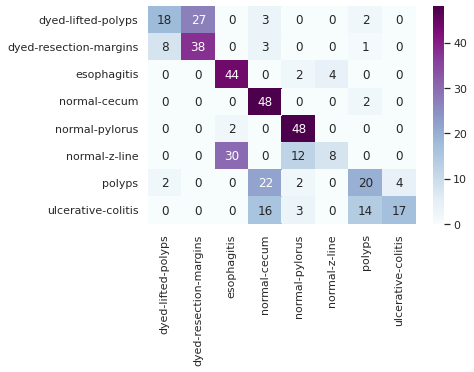

In [71]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, columns=class_names, index=class_names)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="BuPu") # font size

plt.show()

# Hyperparameters tuning

**Caution:** Since tuning code re-trains the model with a number of different hyperparameters, it will take a long time to complete all tests.

In [72]:
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

from keras import layers
from keras import optimizers
from tensorflow.keras import regularizers

In [73]:
def get_model(num_classes = 8, drop_out=0.4, reg=None, n_densenodes=256):

  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, 3, activation='relu', input_shape=(224,224,3), padding='same',
                kernel_regularizer=reg))
  model.add(layers.Conv2D(64, 3, activation='relu', padding='same',
                kernel_regularizer=reg))

  model.add(layers.MaxPooling2D())

  model.add(layers.Conv2D(128, 3, activation='relu',padding='same'))
  model.add(layers.Conv2D(128, 3, activation='relu',padding='same'))
  
  model.add(layers.MaxPooling2D())

  model.add(layers.Conv2D(256, 3, activation='relu',padding='same'))
  model.add(layers.Conv2D(256, 3, activation='relu',padding='same'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Flatten())
  model.add(layers.Dropout(drop_out))

  model.add(layers.Dense(n_densenodes, activation='relu', kernel_regularizer=reg))
  model.add(layers.Dropout(drop_out))
  model.add(layers.Dense(num_classes, activation='softmax', kernel_regularizer=reg))
  
  return model

In [74]:
def optimizer_search(iters=10):
  
  opt1 = optimizers.RMSprop(learning_rate=2e-5)
  opt2 = optimizers.RMSprop(learning_rate=2e-4)
  opt3 = optimizers.SGD(learning_rate=0.001, momentum=0.8)
  opt3 = optimizers.SGD(learning_rate=0.001, momentum=0.8)
  opt3 = optimizers.SGD(learning_rate=0.001, momentum=0.8)
  opt4 = optimizers.SGD(learning_rate=0.001, momentum=0.9)
  opt5 = optimizers.SGD(learning_rate=0.01, momentum=0.8)
  opt6 = optimizers.SGD(learning_rate=0.01, momentum=0.9)
  opt7 = optimizers.SGD(learning_rate=0.0001, momentum=0.8)
  opt8 = optimizers.SGD(learning_rate=0.0001, momentum=0.9)
  opt9 = optimizers.Adam()

  opt_list = [opt1, opt2, opt3, opt4, opt5, opt6, opt7, opt8, opt9]
  opt_name = ['RMSprop(learning_rate=2e-5)', 
              'RMSprop(learning_rate=2e-4)', 
              'SGD(learning_rate=0.001, momentum=0.8)',
              'SGD(learning_rate=0.001, momentum=0.9)',
              'SGD(learning_rate=0.01, momentum=0.8)',
              'SGD(learning_rate=0.01, momentum=0.9)',
              'SGD(learning_rate=0.0001, momentum=0.8)',
              'SGD(learning_rate=0.0001, momentum=0.9)',
              'adam']
  opt_hist=[]

  # regularizers.l2(1e-4)

  # 1. pick optimizer
  
  
  for i, opt in enumerate(opt_list):
    print(opt_name[i])
    model = get_model()
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])
    h = model.fit(train_ds_norm, epochs=15, validation_data = val_ds_norm)
    opt_hist.append(h)
    print("")
  
  return opt_hist, opt_name



  """
  for m in momentums:
    model = get_model()
    opt = tf.keras.optimizers.SGD(lr=best_lr, momentum = m)
    model.compile(optimizer=opt,
                  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    model.fit(normtrain_ds ,epochs=iters)
    score = model.evaluate(normval_ds, verbose=0)
    if score[1] > best_acc:
      best_acc = score[1]
      best_mom = m

  print('best lr: ', best_lr)
  print('best momentum: ', best_mom)"""

  


In [75]:
opt_hist = optimizer_search()

RMSprop(learning_rate=2e-5)
Epoch 1/15
50/50 [==============================] - 16s 299ms/step - loss: 1.5587 - accuracy: 0.4125 - val_loss: 1.0175 - val_accuracy: 0.6750
Epoch 2/15
50/50 [==============================] - 15s 306ms/step - loss: 1.0264 - accuracy: 0.5494 - val_loss: 0.8270 - val_accuracy: 0.6750
Epoch 3/15
50/50 [==============================] - 15s 309ms/step - loss: 0.9239 - accuracy: 0.5850 - val_loss: 0.8272 - val_accuracy: 0.7500
Epoch 4/15
50/50 [==============================] - 16s 324ms/step - loss: 0.8750 - accuracy: 0.6225 - val_loss: 0.8424 - val_accuracy: 0.7000
Epoch 5/15
50/50 [==============================] - 15s 308ms/step - loss: 0.8302 - accuracy: 0.6381 - val_loss: 0.7188 - val_accuracy: 0.7750
Epoch 6/15
50/50 [==============================] - 15s 308ms/step - loss: 0.7916 - accuracy: 0.6456 - val_loss: 0.7148 - val_accuracy: 0.7750
Epoch 7/15
50/50 [==============================] - 15s 308ms/step - loss: 0.7461 - accuracy: 0.6844 - val_loss: 0

In [76]:

def reguralizer_search(iters=10):
  
  opt3 = optimizers.SGD(learning_rate=0.001, momentum=0.8)
  reg1 = regularizers.l2(1e-4)
  reg2 = regularizers.l1(1e-5)
  reg3 = regularizers.l2(1e-5)
  reg4 = regularizers.l2(1e-3)

  reg_list = [reg1, reg2, reg3, reg4]
  reg_name = ['regularizers.l2(1e-4)', 
              'regularizers.l1(1e-5)', 
              'regularizers.l2(1e-5)',
              'regularizers.l2(1e-3)']
  reg_hist=[]

  # regularizers.l2(1e-4)

  # 2. pick regularizer
  for i, r in enumerate(reg_list):
    print(reg_name[i])
    model = get_model(reg=r)
    model.compile(optimizer=opt3, loss="categorical_crossentropy", metrics=['accuracy'])
    h = model.fit(train_ds_norm, epochs=15, validation_data = val_ds_norm)
    reg_hist.append(h)
    print("")
  
  return reg_hist, reg_name



In [77]:
reg_hist = reguralizer_search()

regularizers.l2(1e-4)
Epoch 1/15
50/50 [==============================] - 17s 309ms/step - loss: 2.1283 - accuracy: 0.1569 - val_loss: 2.0965 - val_accuracy: 0.3000
Epoch 2/15
50/50 [==============================] - 16s 316ms/step - loss: 2.0747 - accuracy: 0.2650 - val_loss: 1.9345 - val_accuracy: 0.6250
Epoch 3/15
50/50 [==============================] - 16s 310ms/step - loss: 1.7799 - accuracy: 0.3425 - val_loss: 1.2699 - val_accuracy: 0.4500
Epoch 4/15
50/50 [==============================] - 15s 307ms/step - loss: 1.3195 - accuracy: 0.4675 - val_loss: 1.0197 - val_accuracy: 0.7500
Epoch 5/15
50/50 [==============================] - 15s 305ms/step - loss: 1.1041 - accuracy: 0.5681 - val_loss: 0.8275 - val_accuracy: 0.6750
Epoch 6/15
50/50 [==============================] - 15s 307ms/step - loss: 0.9941 - accuracy: 0.6025 - val_loss: 0.7850 - val_accuracy: 0.7000
Epoch 7/15
50/50 [==============================] - 15s 308ms/step - loss: 0.9344 - accuracy: 0.6206 - val_loss: 0.7824 

# Learn and extract image features

## VGG16

In [78]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

from keras import layers
from keras import optimizers
from tensorflow.keras import regularizers

In [79]:


# load model without classifier layers
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
drop1 = layers.Dropout(0.4)(flat1)
class1 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(drop1)
drop2 = layers.Dropout(0.4)(class1)
output = Dense(8, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(drop2)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [81]:
opt1 = optimizers.SGD(learning_rate=0.01, momentum=0.8)
opt2 = optimizers.RMSprop(learning_rate=2e-5)
opt3="adam"

In [82]:
model.compile(
  optimizer=opt2,
  loss="categorical_crossentropy",
  metrics=['accuracy'])

In [83]:
history1 = model.fit(
  train_ds_norm,
  epochs=20,
  validation_data = val_ds_norm
)

Epoch 1/20
50/50 [==============================] - 27s 473ms/step - loss: 1.7086 - accuracy: 0.3512 - val_loss: 0.9075 - val_accuracy: 0.6750
Epoch 2/20
50/50 [==============================] - 24s 477ms/step - loss: 1.0213 - accuracy: 0.6062 - val_loss: 0.7163 - val_accuracy: 0.7750
Epoch 3/20
50/50 [==============================] - 23s 452ms/step - loss: 0.7800 - accuracy: 0.7013 - val_loss: 0.5664 - val_accuracy: 0.8250
Epoch 4/20
50/50 [==============================] - 23s 452ms/step - loss: 0.6082 - accuracy: 0.7731 - val_loss: 0.5321 - val_accuracy: 0.8250
Epoch 5/20
50/50 [==============================] - 23s 461ms/step - loss: 0.5190 - accuracy: 0.8150 - val_loss: 0.5153 - val_accuracy: 0.8250
Epoch 6/20
50/50 [==============================] - 23s 460ms/step - loss: 0.3974 - accuracy: 0.8531 - val_loss: 0.4061 - val_accuracy: 0.9000
Epoch 7/20
50/50 [==============================] - 23s 456ms/step - loss: 0.3977 - accuracy: 0.8631 - val_loss: 0.5224 - val_accuracy: 0.8250

In [84]:
model.fit(train_all_norm,
          epochs=14)

Epoch 1/14
63/63 [==============================] - 51s 792ms/step - loss: 0.2356 - accuracy: 0.9385
Epoch 2/14
63/63 [==============================] - 29s 464ms/step - loss: 0.1865 - accuracy: 0.9510
Epoch 3/14
63/63 [==============================] - 28s 451ms/step - loss: 0.1418 - accuracy: 0.9660
Epoch 4/14
63/63 [==============================] - 30s 475ms/step - loss: 0.1164 - accuracy: 0.9730
Epoch 5/14
63/63 [==============================] - 28s 446ms/step - loss: 0.0988 - accuracy: 0.9805
Epoch 6/14
63/63 [==============================] - 29s 456ms/step - loss: 0.1000 - accuracy: 0.9845
Epoch 7/14
63/63 [==============================] - 30s 471ms/step - loss: 0.0946 - accuracy: 0.9815
Epoch 8/14
63/63 [==============================] - 28s 445ms/step - loss: 0.0906 - accuracy: 0.9860
Epoch 9/14
63/63 [==============================] - 28s 450ms/step - loss: 0.0652 - accuracy: 0.9925
Epoch 10/14
63/63 [==============================] - 29s 454ms/step - loss: 0.0773 - accura

In [85]:
model.save("vgg16.h5")

In [86]:
from keras.models import load_model

In [87]:
model_vgg = load_model('vgg16.h5')

In [88]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [89]:
vgg_features_model = Model (model_vgg.layers[0].input,  model_vgg.layers[21].output)

In [90]:
vgg_features_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [91]:
model_vgg.evaluate(test_ds_norm)

13/13 [==============================] - 2s 152ms/step - loss: 0.7751 - accuracy: 0.8400


[0.7751054167747498, 0.8399999737739563]

In [92]:
predict_test = model_vgg.predict(test_ds_norm)

13/13 [==============================] - 2s 159ms/step


In [93]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y, axis=1), np.argmax(predict_test, axis=1)))

              precision    recall  f1-score   support

           0       0.91      0.82      0.86        50
           1       0.90      0.92      0.91        50
           2       0.81      0.60      0.69        50
           3       0.88      0.92      0.90        50
           4       0.93      1.00      0.96        50
           5       0.68      0.84      0.75        50
           6       0.76      0.78      0.77        50
           7       0.88      0.84      0.86        50

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400



In [94]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(np.argmax(y, axis=1), np.argmax(predict_test, axis=1), average='weighted')

0.8439436567460761

In [95]:
np.average(recall_score(np.argmax(y, axis=1), np.argmax(predict_test, axis=1), average=None))

0.84

In [96]:
np.average(f1_score(np.argmax(y, axis=1), np.argmax(predict_test, axis=1), average=None))

0.8383279358721702

In [97]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y, axis=1), np.argmax(predict_test, axis=1))

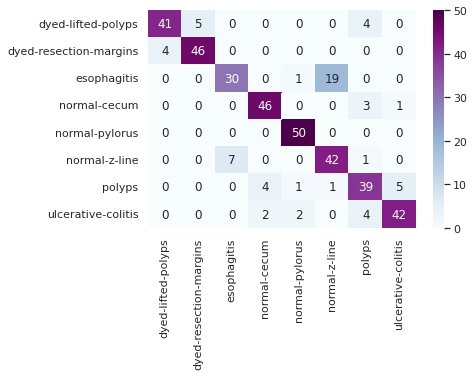

In [98]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, columns=class_names, index=class_names)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="BuPu") # font size

plt.show()

## DenseNet-169

In [99]:
from keras.applications.densenet import DenseNet169
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

from keras import layers
from keras import optimizers

# load model without classifier layers
model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
drop1 = layers.Dropout(0.5)(flat1)
class1 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(drop1)
drop2 = layers.Dropout(0.5)(class1)
output = Dense(8, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(drop2)

# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

51877672/51877672 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                           

In [100]:
model.compile(
  optimizer=optimizers.RMSprop(learning_rate=2e-5),
  loss="categorical_crossentropy",
  metrics=['accuracy'])

In [101]:
history3 = model.fit(
  train_ds_norm,
  epochs=20,
  validation_data = val_ds_norm
)

Epoch 1/20
50/50 [==============================] - 62s 536ms/step - loss: 2.1519 - accuracy: 0.3781 - val_loss: 0.9946 - val_accuracy: 0.6750
Epoch 2/20
50/50 [==============================] - 23s 462ms/step - loss: 1.0048 - accuracy: 0.6506 - val_loss: 0.6571 - val_accuracy: 0.7500
Epoch 3/20
50/50 [==============================] - 23s 456ms/step - loss: 0.6378 - accuracy: 0.7812 - val_loss: 0.4554 - val_accuracy: 0.9250
Epoch 4/20
50/50 [==============================] - 23s 454ms/step - loss: 0.4184 - accuracy: 0.8556 - val_loss: 0.3376 - val_accuracy: 0.8750
Epoch 5/20
50/50 [==============================] - 23s 457ms/step - loss: 0.2843 - accuracy: 0.9156 - val_loss: 0.3142 - val_accuracy: 0.9000
Epoch 6/20
50/50 [==============================] - 23s 457ms/step - loss: 0.2252 - accuracy: 0.9431 - val_loss: 0.3009 - val_accuracy: 0.9500
Epoch 7/20
50/50 [==============================] - 23s 457ms/step - loss: 0.1545 - accuracy: 0.9550 - val_loss: 0.2844 - val_accuracy: 0.9250

In [102]:
model.fit(train_all_norm,
          epochs=17)

Epoch 1/17
63/63 [==============================] - 32s 513ms/step - loss: 0.2223 - accuracy: 0.9595
Epoch 2/17
63/63 [==============================] - 28s 450ms/step - loss: 0.1183 - accuracy: 0.9720
Epoch 3/17
63/63 [==============================] - 28s 450ms/step - loss: 0.0804 - accuracy: 0.9815
Epoch 4/17
63/63 [==============================] - 28s 449ms/step - loss: 0.0592 - accuracy: 0.9865
Epoch 5/17
63/63 [==============================] - 28s 450ms/step - loss: 0.0477 - accuracy: 0.9925
Epoch 6/17
63/63 [==============================] - 28s 450ms/step - loss: 0.0404 - accuracy: 0.9940
Epoch 7/17
63/63 [==============================] - 28s 450ms/step - loss: 0.0280 - accuracy: 0.9990
Epoch 8/17
63/63 [==============================] - 28s 450ms/step - loss: 0.0331 - accuracy: 0.9980
Epoch 9/17
63/63 [==============================] - 28s 450ms/step - loss: 0.0364 - accuracy: 0.9950
Epoch 10/17
63/63 [==============================] - 28s 450ms/step - loss: 0.0292 - accura

In [103]:
model.evaluate(test_ds_norm)

13/13 [==============================] - 2s 112ms/step - loss: 1.3038 - accuracy: 0.8725


[1.3038140535354614, 0.8725000023841858]

In [104]:
predict_test = model.predict(test_ds_norm)

13/13 [==============================] - 4s 113ms/step


In [105]:
predict_test.shape

(400, 8)

In [106]:
model.save("densenet.h5")

In [107]:
from keras.models import load_model
model_dn = load_model('densenet.h5')

In [108]:
model_dn.summary ()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [109]:
dn_features_model = Model (model_dn.layers[0].input,  model_dn.layers[597].output)

In [110]:
dn_features_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [111]:
pred_test = model.predict(test_ds_norm)

13/13 [==============================] - 1s 111ms/step


In [112]:
from sklearn.metrics import precision_score, recall_score, f1_score
np.average(precision_score(np.argmax(y, axis=1), np.argmax(pred_test, axis=1), average='weighted'))

0.8734547515467912

In [113]:
from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(np.argmax(y, axis=1), np.argmax(predict_test, axis=1))
#cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_test, axis=1))
cm = confusion_matrix(np.argmax(y, axis=1), np.argmax(pred_test, axis=1))

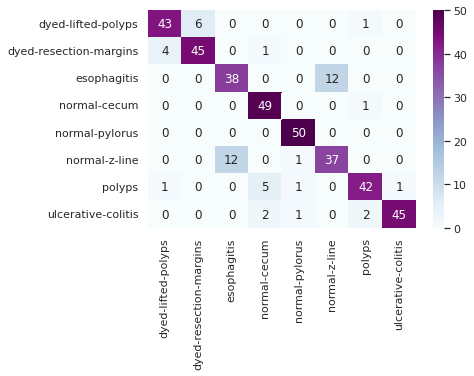

In [114]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, columns=class_names, index=class_names)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="BuPu") # font size

plt.show()

# Save features to pickle file for future use

In [115]:
import pandas as pd

In [116]:
vgg_features = vgg_features_model.predict(train_ds_norm)
vgg_features_val = vgg_features_model.predict(val_ds_norm)
vgg_features_test = vgg_features_model.predict(test_ds_norm)

13/13 [==============================] - 2s 158ms/step


In [117]:
df_features = pd.DataFrame(vgg_features)
df_features.to_pickle("vgg_features.pkl")
df_features = pd.DataFrame(vgg_features_val)
df_features.to_pickle("vgg_features_val.pkl")
df_features = pd.DataFrame(vgg_features_test)
df_features.to_pickle("vgg_features_test.pkl")

In [118]:
dn_features = dn_features_model.predict(train_ds_norm)
dn_features_val = dn_features_model.predict(val_ds_norm)
dn_features_test = dn_features_model.predict(test_ds_norm)

13/13 [==============================] - 1s 104ms/step


In [119]:
y_train = np.concatenate([y for x, y in train_ds_norm], axis=0)
y_val = np.concatenate([y for x, y in val_ds_norm], axis=0)
y_test = np.concatenate([y for x, y in test_ds_norm], axis=0)

In [120]:
df_features = pd.DataFrame(dn_features)
df_features["label"] = np.argmax(y_train, axis=1)
df_features.to_pickle("dn_features.pkl")

df_features = pd.DataFrame(dn_features_val)
df_features["label"] = np.argmax(y_val, axis=1)
df_features.to_pickle("dn_features_val.pkl")

df_features = pd.DataFrame(dn_features_test)
df_features["label"] = np.argmax(y_test, axis=1)
df_features.to_pickle("dn_features_test.pkl")

In [121]:
import pandas as pd
import numpy as np

In [122]:
vgg_features = np.array(pd.read_pickle("vgg_features.pkl"))
dn_features = np.array(pd.read_pickle("dn_features.pkl"))
vgg_features_val = np.array(pd.read_pickle("vgg_features_val.pkl"))
dn_features_val = np.array(pd.read_pickle("dn_features_val.pkl"))
vgg_features_test = np.array(pd.read_pickle("vgg_features_test.pkl"))
dn_features_test = np.array(pd.read_pickle("dn_features_test.pkl"))

In [123]:
# extract class labels
y_train = dn_features[:,-1]
y_val = dn_features_val[:,-1]
y_test = dn_features_test[:,-1]

In [124]:
dn_features_val = dn_features_val[:,:-1]
dn_features = dn_features[:,:-1]
dn_features_test = dn_features_test[:,:-1]

In [125]:
combined_features = np.concatenate ((dn_features, vgg_features), axis=1)
combined_features_val = np.concatenate ((dn_features_val, vgg_features_val), axis=1)
combined_features_test = np.concatenate ((dn_features_test, vgg_features_test), axis=1)

In [126]:
# 256 features from VGG16 + 256 features from DenseNet169
print ("combined_features.shape: ", combined_features.shape)
print ("combined_features_val.shape: ", combined_features_val.shape)
print ("combined_features_test.shape: ", combined_features_test.shape)

combined_features.shape:  (1600, 512)
combined_features_val.shape:  (40, 512)
combined_features_test.shape:  (400, 512)


In [127]:
import time
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

In [128]:
feat_cols = [ 'pixel'+str(i) for i in range(combined_features.shape[1]) ]
df = pd.DataFrame(combined_features,columns=feat_cols)
df['class'] = y_train
df['label'] = df['class'].apply(lambda i: str(i))
X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (1600, 514)


In [129]:
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

In [130]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [131]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=5000)
tsne_results = tsne.fit_transform(df[feat_cols].values)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1600 samples in 0.012s...
[t-SNE] Computed neighbors for 1600 samples in 0.244s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1600
[t-SNE] Computed conditional probabilities for sample 1600 / 1600
[t-SNE] Mean sigma: 7.731935
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.422932
[t-SNE] KL divergence after 5000 iterations: 0.650252
t-SNE done! Time elapsed: 32.90897822380066 seconds


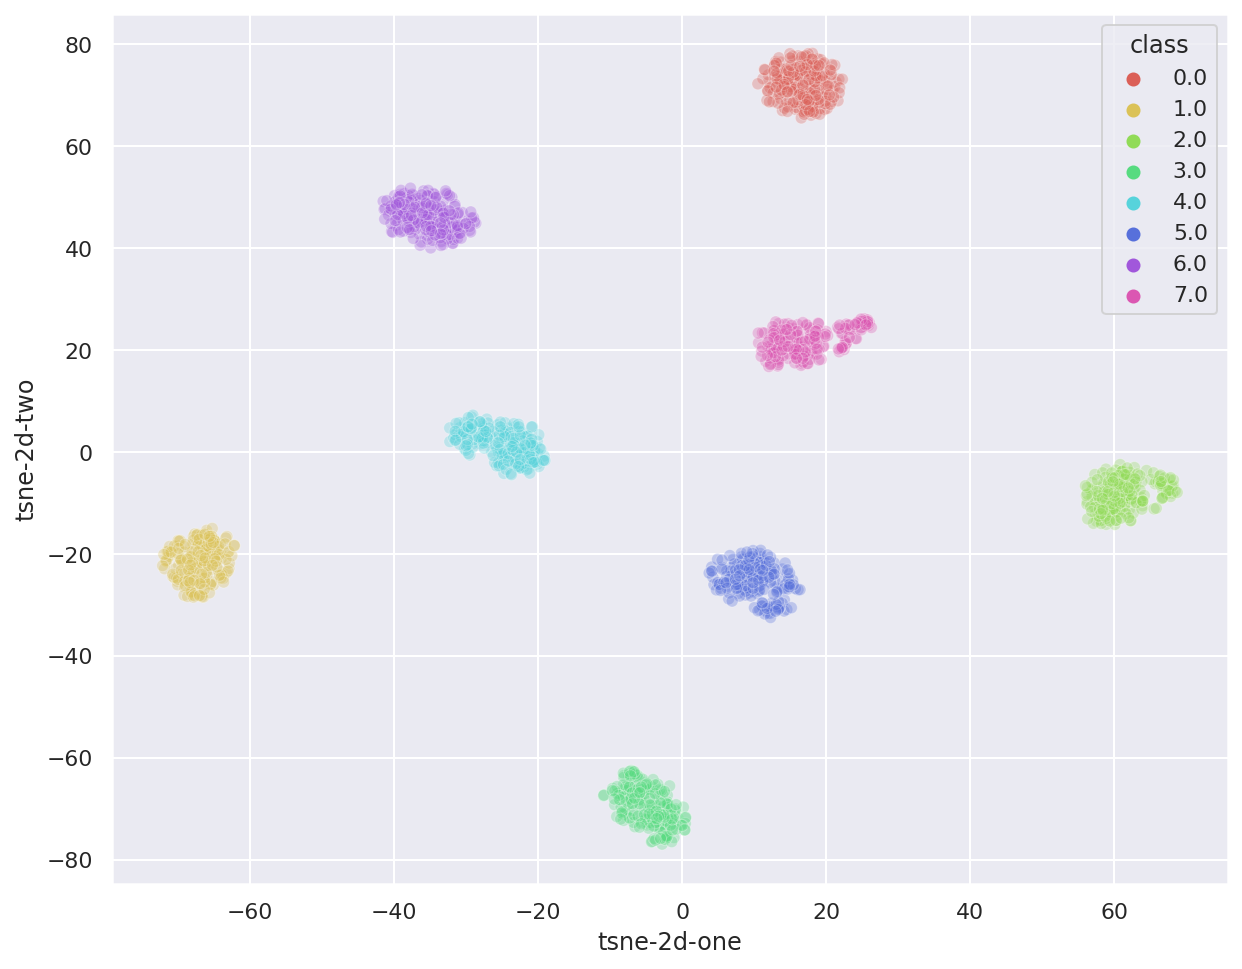

In [132]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(10,8))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class",
    palette=sns.color_palette("hls", 8),
    data=df,
    legend="full",
    alpha=0.3
)

In [133]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [134]:
lr = LogisticRegression(max_iter=10000)

In [135]:
combined_features_all = np.concatenate((combined_features, combined_features_val))
y_train_all = np.concatenate((y_train, y_val))

In [136]:
combined_features_all.shape

(1640, 512)

In [137]:
y_train_all.shape

(1640,)

In [138]:
lr.fit(combined_features, y_train)

LogisticRegression(max_iter=10000)

In [139]:
from sklearn.metrics import accuracy_score

# training set accuracy
y_pred = lr.predict(combined_features_test)
accuracy_score( y_test, y_pred)

0.87

In [140]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [141]:
precision_score(y_test, y_pred, average="weighted")

0.8702004922398998

In [142]:
recall_score(y_test, y_pred, average="weighted")

0.87

In [143]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [144]:
cm

array([[42,  5,  0,  0,  0,  0,  2,  1],
       [ 5, 45,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 40,  0,  0, 10,  0,  0],
       [ 0,  0,  0, 49,  0,  0,  1,  0],
       [ 0,  0,  0,  0, 50,  0,  0,  0],
       [ 0,  0, 13,  0,  1, 35,  1,  0],
       [ 0,  0,  0,  6,  1,  0, 42,  1],
       [ 0,  0,  0,  2,  1,  0,  2, 45]])

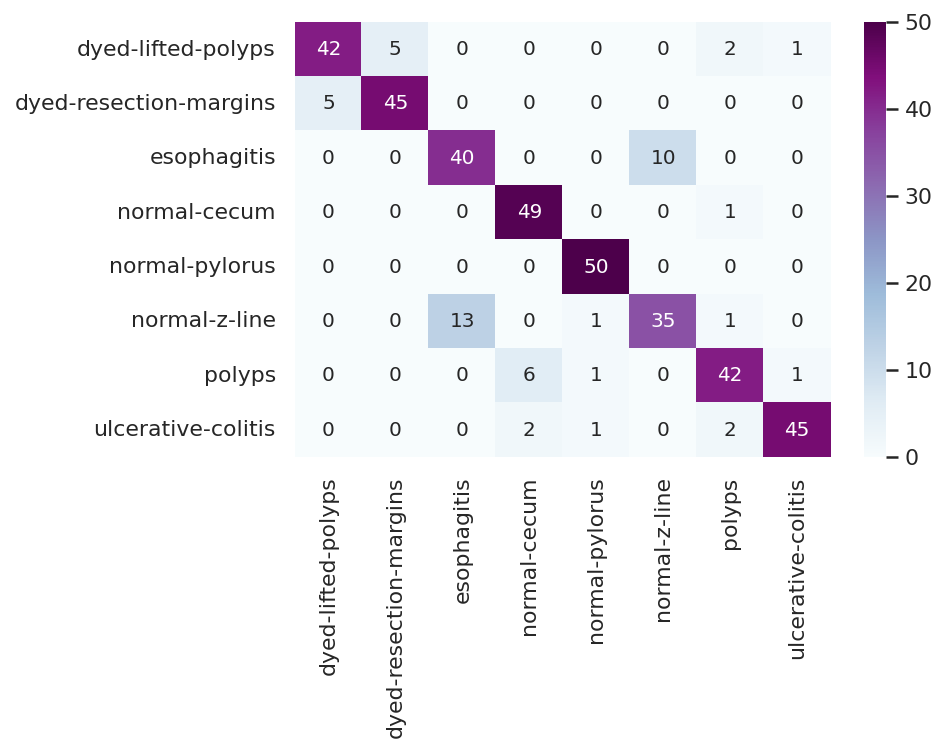

In [145]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
class_names = ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']
df_cm = pd.DataFrame(cm, columns=class_names, index=class_names)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="BuPu") # font size

plt.show()

In [146]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [147]:
mlp = MLPClassifier()
mlp.fit(combined_features, y_train)

MLPClassifier()

In [148]:
dt = DecisionTreeClassifier()
dt.fit(combined_features, y_train)

DecisionTreeClassifier()

In [149]:
neigh = KNeighborsClassifier(n_neighbors=20)
neigh.fit(combined_features, y_train)

KNeighborsClassifier(n_neighbors=20)

In [150]:
pred_test1 = neigh.predict(combined_features_test)

In [151]:
pred_test2 = dt.predict(combined_features_test)

In [152]:
pred_test3 = mlp.predict(combined_features_test)

In [153]:
accuracy_score(y_test, pred_test1) # KNeighborsClassifier accuracy

0.8725

In [154]:
accuracy_score(y_test, pred_test2) # DecisionTreeClassifier accuracy

0.795

In [155]:
accuracy_score(y_test, pred_test3) # MLP classifier accuracy

0.87